Zhi Poh's snack classifier project

My Office has a pantry that functions on a honour pay system along with its price. I was wondering if I could automatically identify the snack so that we could calculate the prices quicker for payment.

In [ ]:
# importing the libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
import pandas as pd
from google.colab import drive, files

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# check if the files are correct
# each folder contains slightly over 100 images of the snack at various perspective
! ls '/content/drive/My Drive/Snacks'

'Fanta Orange'	"Julie's Cheese"  'Kit Kat'   Milo   Oreo   test  'Yan Yan'


In [ ]:
# set directory to the snacks folders
os.chdir('/content/drive/My Drive/Snacks')

In [ ]:
# generate the dataset and labelling the classes for each image into a Dataframe df
path = "./"

data = []
for root, dirs, files in os.walk(path, topdown=True):
  for name in files:
    if '.jpg' not in name:
      continue
    filename = os.path.abspath(os.path.join(root, name))
    class_name = os.path.basename(root)
    data.append((filename, class_name))
    
df = pd.DataFrame(data, columns=['filename', 'class_name'])

df['class_name'] = df['class_name'].astype('category')
df['class'] = df['class_name'].cat.codes

#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename      class_name  class
0          /content/drive/My Drive/Snacks/Oreo/0.jpg            Oreo      4
1  /content/drive/My Drive/Snacks/Fanta Orange/9.jpg    Fanta Orange      0
2  /content/drive/My Drive/Snacks/Julie's Cheese/...  Julie's Cheese      1
3      /content/drive/My Drive/Snacks/Kit Kat/52.jpg         Kit Kat      2
4        /content/drive/My Drive/Snacks/Milo/118.jpg            Milo      3
866


filename        object
class_name    category
class             int8
dtype: object

In [ ]:
# Split into train and validation sets
train_set_percentage = .8


df_train = df[:int(len(df)*train_set_percentage)]
df_val = df[int(len(df)*train_set_percentage):]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)

In [ ]:
# we have 692 training RGB images and 174 test RGB images
df_train.shape, df_val.shape

((692, 3), (174, 3))

In [ ]:
# Reads an image from a file, decodes it into a tensor, and resizes it to 64 by 64 pixels
# to a fixed shape.
img_rows, img_cols = 64, 64
num_classes = 6
# batch size set to 16
batch_size = 16

# converts the images to tensors
def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string,channels=3)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [ ]:
# batch for training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
# batch for test dataset
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [ ]:
train_dataset

<BatchDataset shapes: ((16, 64, 64, 3), (16, 6)), types: (tf.float32, tf.float32)>

In [ ]:
# create the base pre-trained model
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3),pooling=None)

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K


# add a global spatial average pooling layer
x = base_model.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)


In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False


input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [ ]:
for layer in model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
opt = tf.keras.optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
train_steps = int(692/16) #total trains set / batch_size
val_steps = int(174/16)

print('train steps:',train_steps)
print('val steps:',val_steps)

train steps: 43
val steps: 10


In [ ]:
### Train the model with validation 
history = model.fit( train_dataset, 
                    steps_per_epoch = train_steps,
                    epochs = 5,
                    verbose = 1,
                    validation_data = valid_dataset,
                    validation_steps = val_steps)

Epoch 1/5
43/43 [==============================] - 80s 2s/step - loss: 5.7808 - accuracy: 0.6366 - val_loss: 0.5993 - val_accuracy: 0.9125
Epoch 2/5
43/43 [==============================] - 1s 16ms/step - loss: 0.5697 - accuracy: 0.9244 - val_loss: 0.2068 - val_accuracy: 0.9500
Epoch 3/5
43/43 [==============================] - 1s 16ms/step - loss: 0.2382 - accuracy: 0.9506 - val_loss: 0.1034 - val_accuracy: 0.9625
Epoch 4/5
43/43 [==============================] - 1s 16ms/step - loss: 0.0627 - accuracy: 0.9811 - val_loss: 0.1001 - val_accuracy: 0.9500
Epoch 5/5
43/43 [==============================] - 2s 38ms/step - loss: 0.1142 - accuracy: 0.9724 - val_loss: 0.1061 - val_accuracy: 0.9563


In [ ]:
metrics = model.evaluate(valid_dataset,
                   steps = val_steps)
print("model accuracy:",metrics[1])

10/10 [==============================] - 0s 28ms/step - loss: 0.1061 - accuracy: 0.9563
model accuracy: 0.956250011920929


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as ply
from IPython.display import Image, display
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions


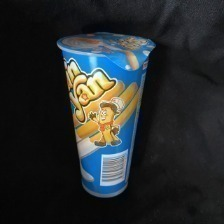

Input image shape: (1, 96, 96, 3)
Predicted: [[2.0627317e-06 2.0394307e-12 2.5815501e-09 4.8630783e-13 7.5333793e-12
  9.9999797e-01]]
Predicted: yan yan Actual: Yan Yan


In [ ]:
# Yan Yan snacks
image_path = './test/yanyan.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Yan Yan" )

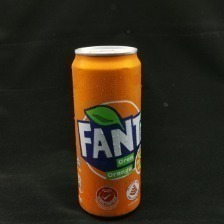

Input image shape: (1, 96, 96, 3)
Predicted: [[9.9999917e-01 6.4567085e-10 3.6637965e-10 4.6308082e-07 4.1610968e-11
  3.5401027e-07]]
Predicted: fanta orange Actual: Fanta Orange


In [ ]:
image_path = './test/fanta.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Fanta Orange")

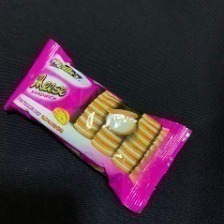

Input image shape: (1, 96, 96, 3)
Predicted: [[4.43971837e-09 9.99991059e-01 3.81342180e-10 1.01755084e-13
  6.11985388e-06 2.87534544e-06]]
Predicted: julie's cheese Actual: Julie's Cheese


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as ply
from IPython.display import Image, display
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

image_path = './test/julies.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Julie's Cheese")

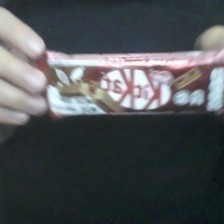

Input image shape: (1, 96, 96, 3)
Predicted: [[2.7268538e-02 2.3333151e-02 9.4900304e-01 3.8475366e-04 1.0353518e-06
  9.4841525e-06]]
Predicted: kit kat Actual: Kit Kat


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as ply
from IPython.display import Image, display
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

image_path = './test/kitkat.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Kit Kat")

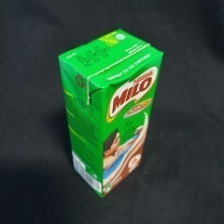

Input image shape: (1, 96, 96, 3)
Predicted: [[3.4282409e-04 3.0933183e-01 1.4150284e-02 4.5653783e-06 3.4448373e-04
  6.7582601e-01]]
Predicted: yan yan Actual: Milo


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as ply
from IPython.display import Image, display
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

image_path = './test/milo.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Milo")

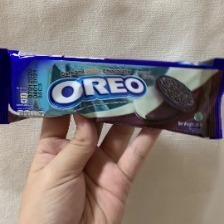

Input image shape: (1, 96, 96, 3)
Predicted: [[9.3305659e-01 1.6517889e-02 5.0314777e-02 3.9013677e-05 2.2973059e-06
  6.9441900e-05]]
Predicted: fanta orange Actual: Oreo


In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as ply
from IPython.display import Image, display
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions

image_path = './test/oreo.jpg'

img = Image(image_path)
display(img)
label = ['fanta orange', "julie's cheese", 'kit kat', 'milo', 'oreo', 'yan yan']
img = image.load_img(image_path, target_size=(96, 96))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)

preds = model.predict(x)
print('Predicted:', preds)
print("Predicted:", label[np.argmax(preds)], "Actual: Oreo")

Conclusion:

We managed to predict 4 out of 6 attempts right! It's working in being able to identify the images.

Potentially the reason why the labels did not work out well with the incorrect labels could be due to the low number of images used to train.

Where to improve on further from here? Increasing datasets and more similar images. For example, being able to identify the different types of flavours of each snacks using multi-class labelling.

Example: [Fanta, Cherry], [Oreo, original], [Julie's, Peanut], [Kit Kat, Matcha]